In [188]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [189]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Number of classes

In [190]:
NUM_CLASSES = 6

# Reading training data

In [191]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [192]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [194]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [195]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_20 (Dropout)        (None, 42)                0         
                                                                 
 dense_30 (Dense)            (None, 20)                860       
                                                                 
 dropout_21 (Dropout)        (None, 20)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                210       
                                                                 
 dense_32 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [196]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [197]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [198]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/24 [>.............................] - ETA: 6s - loss: 1.7484 - accuracy: 0.3828
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 1.7670 - accuracy: 0.3427 - val_loss: 1.5440 - val_accuracy: 0.4086
Epoch 2/1000
 1/24 [>.............................] - ETA: 0s - loss: 1.7253 - accuracy: 0.3047
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 3ms/step - loss: 1.5611 - accuracy: 0.3678 - val_loss: 1.4084 - val_accuracy: 0.5713
Epoch 3/1000
 1/24 [>.............................] - ETA: 0s - loss: 1.4450 - accuracy: 0.4375
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 3ms/step - loss: 1.4133 - accuracy: 0.4558 - val_loss: 1.2595 - val_accuracy: 0.6606
Epoch 4/1000
 1/24 [>.............................] - ETA: 0s - loss: 1.3737 - accuracy: 0.4688
E

In [199]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.9809


In [200]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [201]:
# Model prediction - Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[9.6782178e-01 3.2178219e-02 1.2407899e-14 1.0621603e-18 2.6581700e-23
 1.3925764e-19]
0


# mixed row

32/32 [==============================] - 0s 1ms/step


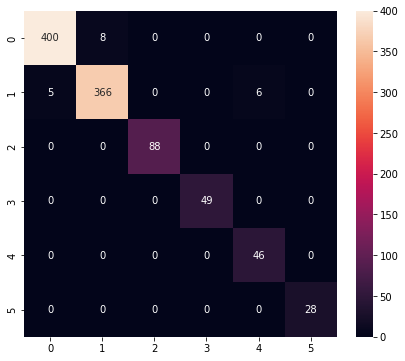

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       408
           1       0.98      0.97      0.97       377
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        49
           4       0.88      1.00      0.94        46
           5       1.00      1.00      1.00        28

    accuracy                           0.98       996
   macro avg       0.98      0.99      0.98       996
weighted avg       0.98      0.98      0.98       996



In [202]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [203]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [204]:
# Transforming the model (quantization)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~2\AppData\Local\Temp\tmpouz1hjqw\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~2\AppData\Local\Temp\tmpouz1hjqw\assets


6668

# Inference test

In [205]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [206]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [207]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [208]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [209]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.67821777e-01 3.21782194e-02 1.24078985e-14 1.06215636e-18
 2.65817000e-23 1.39257653e-19]
0
